In [3]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,  learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [4]:
import nltk
from nltk.corpus import stopwords

#downloading the stopwords..
nltk.download('stopwords')


#accessing the stopwords of english..
stop_words = set(stopwords.words('english'))

print(stop_words)

{'because', 'too', 'while', "you're", 'been', "couldn't", 'am', "mightn't", 'hers', 'is', 'same', 'their', 'out', 'will', 'needn', 'it', "needn't", "you've", 'wouldn', 'than', 'y', 'have', 'being', 'over', 'doesn', 'of', 'during', 'on', 'can', 's', 'or', 'doing', 'had', 'as', 'and', "hasn't", 'those', "won't", 'i', 'my', 'at', 'an', "you'd", 'to', 'where', 'with', "didn't", 'between', "it's", "isn't", 'theirs', 'both', "mustn't", 'mightn', 'him', 'all', 'himself', 'yourself', "wasn't", 'haven', 'll', 'down', 'under', "wouldn't", 'didn', 'so', 'in', 'our', 'against', 'there', 'his', 'after', 'this', 'they', 'do', 'hasn', 'ain', 'shan', 'yours', 'hadn', 'below', 'shouldn', 'what', 'then', 'your', 'these', 'not', 'her', 'which', 'has', "shan't", 'until', 'by', 'for', 'them', 'couldn', 'was', 'itself', 'he', 'again', 'about', 'own', 'nor', "shouldn't", 'up', 'each', 'did', 'now', 'off', 'most', 'once', 'a', "aren't", 'whom', 'further', 're', 'some', 'ma', 'very', "hadn't", 'but', 've', 'th

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\omi84\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
pd.set_option('display.width', 1000)

#Loading the data...
news_data  = pd.read_csv(r"C:\Users\omi84\OneDrive\Desktop\Anveshan\Fake-News-Prediction\assets\train.csv")
news_data.shape, news_data.head(), news_data.describe()

((20800, 5),
    id                                              title              author                                               text  label
 0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus  House Dem Aide: We Didn’t Even See Comey’s Let...      1
 1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn  Ever get the feeling your life circles the rou...      0
 2   2                  Why the Truth Might Get You Fired  Consortiumnews.com  Why the Truth Might Get You Fired October 29, ...      1
 3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss  Videos 15 Civilians Killed In Single US Airstr...      1
 4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy  Print \nAn Iranian woman has been sentenced to...      1,
                  id         label
 count  20800.000000  20800.000000
 mean   10399.500000      0.500625
 std     6004.587135      0.500012
 min        0.000000      0.00

In [6]:
#counting the missing value...
news_data.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [7]:
#replacing the null with empty strings...
news_data = news_data.fillna('')

In [8]:
news_data.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [9]:
#merging the author & title..
news_data['content'] = news_data['author']+' '+news_data['title']
news_data

,id,title,author,text,label,content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Consortiumnews.com Why the Truth Might Get You...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,Jessica Purkiss 15 Civilians Killed In Single ...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Howard Portnoy Iranian woman jailed for fictio...
...,...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0,Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0,"Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma..."
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0,Michael J. de la Merced and Rachel Abrams Macy...
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1,"Alex Ansary NATO, Russia To Hold Parallel Exer..."


In [10]:
#apply stemming...
port_stem = PorterStemmer()

In [11]:
def stemming(content) :
    stemmed_content = re.sub('[^a-zA-Z]',' ', content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stop_words]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [12]:
news_data['content'] = news_data['content'].apply(stemming)

In [13]:
print(news_data['content'])

0        darrel lucu hous dem aid even see comey letter...
1        daniel j flynn flynn hillari clinton big woman...
2                   consortiumnew com truth might get fire
3        jessica purkiss civilian kill singl us airstri...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper trump poster child white s...
20796    benjamin hoffman n f l playoff schedul matchup...
20797    michael j de la merc rachel abram maci said re...
20798    alex ansari nato russia hold parallel exercis ...
20799                            david swanson keep f aliv
Name: content, Length: 20800, dtype: object


In [14]:
# Separating the data & label..
X = news_data['content'].values
Y = news_data['label']
X.shape, Y.shape, X, Y

((20800,),
 (20800,),
 array(['darrel lucu hous dem aid even see comey letter jason chaffetz tweet',
        'daniel j flynn flynn hillari clinton big woman campu breitbart',
        'consortiumnew com truth might get fire', ...,
        'michael j de la merc rachel abram maci said receiv takeov approach hudson bay new york time',
        'alex ansari nato russia hold parallel exercis balkan',
        'david swanson keep f aliv'], dtype=object),
 0        1
 1        0
 2        1
 3        1
 4        1
         ..
 20795    0
 20796    0
 20797    0
 20798    1
 20799    1
 Name: label, Length: 20800, dtype: int64)

In [15]:
# converting the textuall data to numerical data...
vectorizer = TfidfVectorizer()
vectorizer.fit(X)

X = vectorizer.transform(X)

In [16]:
print(X)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 210687 stored elements and shape (20800, 17128)>
  Coords	Values
  (0, 267)	0.2701012497770876
  (0, 2483)	0.36765196867972083
  (0, 2959)	0.24684501285337127
  (0, 3600)	0.3598939188262558
  (0, 3792)	0.27053324808454915
  (0, 4973)	0.23331696690935097
  (0, 7005)	0.2187416908935914
  (0, 7692)	0.24785219520671598
  (0, 8630)	0.2921251408704368
  (0, 8909)	0.36359638063260746
  (0, 13473)	0.2565896679337956
  (0, 15686)	0.2848506356272864
  (1, 1497)	0.2939891562094648
  (1, 1894)	0.15521974226349364
  (1, 2223)	0.3827320386859759
  (1, 2813)	0.19094574062359204
  (1, 3568)	0.26373768806048464
  (1, 5503)	0.7143299355715573
  (1, 6816)	0.1904660198296849
  (1, 16799)	0.30071745655510157
  (2, 2943)	0.3179886800654691
  (2, 3103)	0.46097489583229645
  (2, 5389)	0.3866530551182615
  (2, 5968)	0.3474613386728292
  (2, 9620)	0.49351492943649944
  :	:
  (20797, 3643)	0.2115550061362374
  (20797, 7042)	0.21799048897828685
  (2079

In [17]:
#splitting the dataset..
X_train, X_test, Y_Train,  Y_Test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)
print(X_train, X_test, Y_Train, Y_Test)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 168288 stored elements and shape (16640, 17128)>
  Coords	Values
  (0, 336)	0.3360072514082535
  (0, 2794)	0.3776836172783757
  (0, 3155)	0.3400831511004003
  (0, 10219)	0.3019527708144002
  (0, 10306)	0.09662001419895176
  (0, 11936)	0.24142639024498436
  (0, 12501)	0.3929876463935473
  (0, 13014)	0.2680313811122545
  (0, 13914)	0.3334797245354899
  (0, 15295)	0.09807665903342763
  (0, 16928)	0.3360072514082535
  (0, 16996)	0.09995656818816077
  (1, 920)	0.29734620451870225
  (1, 956)	0.28555808026281854
  (1, 2207)	0.3387500815971264
  (1, 2761)	0.3387500815971264
  (1, 5313)	0.2768869285533855
  (1, 9856)	0.3387500815971264
  (1, 10061)	0.2492488906549133
  (1, 10306)	0.0702073615362174
  (1, 11421)	0.30846662831451355
  (1, 13453)	0.3387500815971264
  (1, 15295)	0.07126580880898772
  (1, 15417)	0.2661317023813158
  (1, 15424)	0.2257940483692803
  :	:
  (16637, 10306)	0.08480680178356828
  (16637, 11715)	0.337660375859258

In [18]:
model = LogisticRegression()
model.fit(X_train, Y_Train)

LogisticRegression()

In [19]:
#Evakuating the model...
training_prediction = model.predict(X_train)
training_prediction_score = accuracy_score(training_prediction, Y_Train)
print("Training accuracy score of the model : ", training_prediction_score)

Training accuracy score of the model :  0.9863581730769231


In [20]:
testing_prediction = model.predict(X_test)
testing_prediction_score = accuracy_score(testing_prediction, Y_Test)
print("Testing accuracy score of the model : ", testing_prediction_score)

Testing accuracy score of the model :  0.9790865384615385


In [21]:
#Making a prediction application...
import random
r = random.sample(range(1, 100), 10)

for i in range(10):
    prediction = model.predict(X_test[r[i]])
    print(prediction, end='\t')
        
    if prediction[0] == 0:
        print("Real News!!")
    else:
        print("Fake News!!")

[1]	Fake News!!
[1]	Fake News!!
[1]	Fake News!!
[0]	Real News!!
[0]	Real News!!
[0]	Real News!!
[1]	Fake News!!
[0]	Real News!!
[1]	Fake News!!
[0]	Real News!!


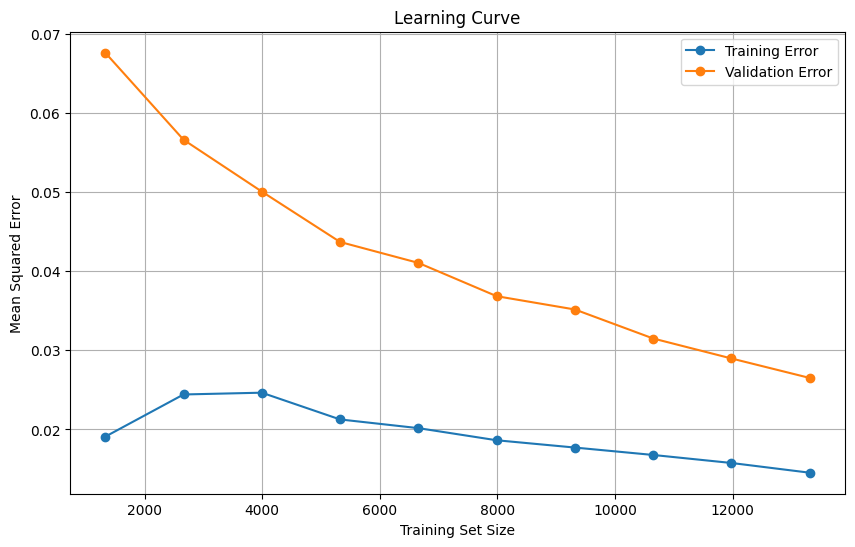

In [22]:
# Generate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, Y_Train, cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Convert negative MSE to positive for plotting
train_scores_mean = -train_scores.mean(axis=1)
val_scores_mean = -val_scores.mean(axis=1)

# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Error', marker='o')
plt.plot(train_sizes, val_scores_mean, label='Validation Error', marker='o')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid()
plt.show()
